In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# mnist dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

from dataset_tools import OwnDataset, make_train_test_val_split
from plotting import (
    plot_split_stratification,
    show_img, 
    loss_plots, 
    plot_random_images, 
    plot_image_comparison, 
    plot_latent_train, 
    plot_latent)
from collections import defaultdict


cuda = torch.cuda.is_available()
print(cuda)

True


# Data

In [2]:
tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.view(-1)) # notice that we dont flatten when we are going to use CNN
])
# dataset = OwnDataset(transform=tf)
dataset = OwnDataset(transform=tf, path=r"C:\Users\Otto\Desktop\Fagprojekt_data\labelled_data")
train_subset, test_subset, val_subset = make_train_test_val_split(dataset)




train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, pin_memory=cuda)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=True, pin_memory=cuda)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=True, pin_memory=cuda)

print(len(dataset), len(train_loader), len(test_loader), len(val_loader))

488396 4884 1527 1221


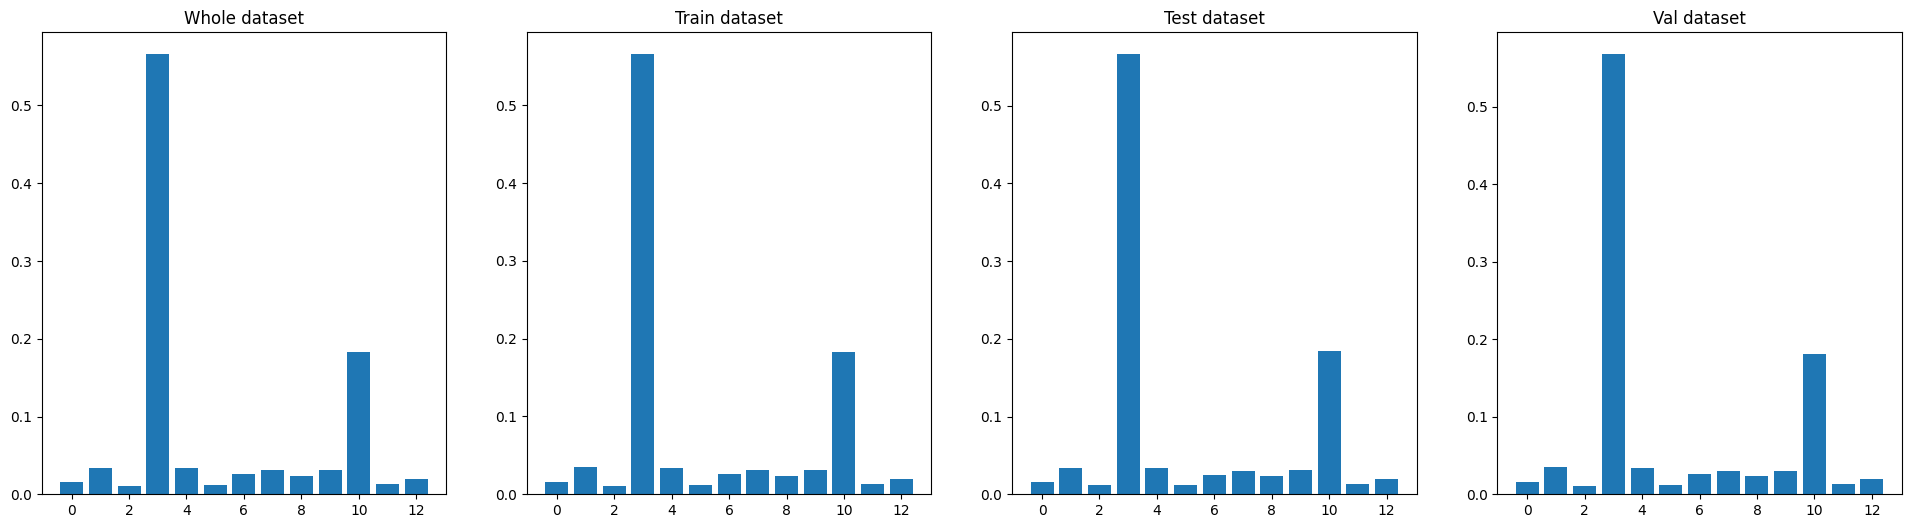

In [3]:
plot_split_stratification(dataset, train_subset, test_subset, val_subset)

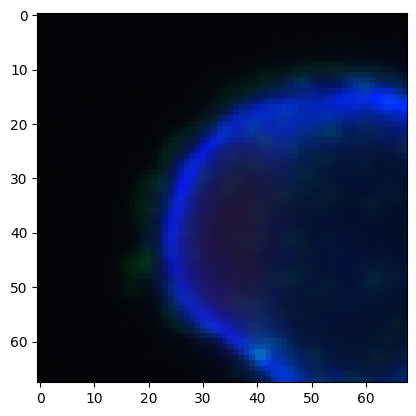

'Actin disruptors'

In [4]:
# get a sample image from the dataset
sample = dataset[612][0]
label = dataset[612][1]

# show the image
show_img(sample.view(3,68,68))

# moa
# data_train.dataset.class_to_idx
dataset.dataset.classes[label]


In [5]:
from models import LatentClassifier, VAE_CELL_CNN, LatentClassifier_2

# load pre-trained model
latent_dim = 32
hidden_dim = 2*latent_dim

# define dirs for the saving of model / data
MODEL_DIR = "trained_models/"
TRAIN_DATA_DIR = "train_data/"

vae = VAE_CELL_CNN(input_dim=(3,68,68), hidden_dim=hidden_dim, latent_dim=latent_dim)
# vae.load_state_dict(torch.load(MODEL_DIR + f"VAE_CELL_CNN_latent{latent_dim}_mean_best_model.pth"))
vae.load_state_dict(torch.load(MODEL_DIR + f"VAE_CELL_CNN_latent{latent_dim}_mean_best_model.pth"))
vae.eval()
latent_classifier = LatentClassifier_2(latent_dim=latent_dim, hidden_dim=hidden_dim, num_classes=len(dataset.dataset.classes))
print(vae)
print(latent_classifier)


MODEL_NAME = f"{latent_classifier.__class__.__name__}_latent{latent_classifier.latent_dim}_mean_"
print(MODEL_NAME)


if cuda:
    vae = vae.cuda()
    latent_classifier = latent_classifier.cuda()

optimizer = optim.Adam(latent_classifier.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(latent_classifier):,} trainable parameters')



VAE_CELL_CNN(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=20736, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=20736, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Unflatten(dim=1, unflattened_size=(256, 9, 9))
    (5): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): LeakyReLU(n

In [6]:
# test forward pass
x, y = next(iter(train_loader))
print(f"x.shape: {x.shape}")

if cuda:
    x = x.cuda()

output = vae(x)
x_hat = output["x_hat"]
z = output["z"]
print(f"x_hat.shape: {x_hat.shape}")
assert x_hat.shape == x.shape

# test latent model
output_latent = latent_classifier(z)
print(f"output_latent.shape: {output_latent.shape}")

# output.shape

x.shape: torch.Size([64, 3, 68, 68])
x_hat.shape: torch.Size([64, 3, 68, 68])
output_latent.shape: torch.Size([64, 13])


# Training loop

In [7]:
val = True

num_epochs = 50

train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []
best_loss = np.inf

for epoch in range(num_epochs):
    latent_classifier.train()
    batch_loss = []
    batch_accuracy = []

    for x, y in train_loader:
        if cuda:
            x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()

        output = vae(x)
        x_hat = output["x_hat"]
        z = output["z"]

        output_latent = latent_classifier(z)
        loss = loss_fn(output_latent, y)
        loss.backward()
        optimizer.step()

        batch_loss.append(loss.item())
        batch_accuracy.append((output_latent.argmax(1) == y).float().mean().item())

    train_loss.append(np.mean(batch_loss))
    train_accuracy.append(np.mean(batch_accuracy))

    if val:
        latent_classifier.eval()
        val_batch_loss = []
        val_batch_accuracy = []
        with torch.no_grad():
            for x, y in val_loader:
                if cuda:
                    x, y = x.cuda(), y.cuda()

                output = vae(x)
                x_hat = output["x_hat"]
                z = output["z"]

                output_latent = latent_classifier(z)
                loss = loss_fn(output_latent, y)

                val_batch_loss.append(loss.item())
                val_batch_accuracy.append((output_latent.argmax(1) == y).float().mean().item())

            val_loss.append(np.mean(val_batch_loss))
            val_accuracy.append(np.mean(val_batch_accuracy))

            if val_loss[-1] < best_loss:
                best_loss = val_loss[-1]
                torch.save(latent_classifier.state_dict(), MODEL_DIR + MODEL_NAME + "best_model.pth")

    
    print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}, accuracy: {train_accuracy[-1]} val_loss: {val_loss[-1]}, val_accuracy: {val_accuracy[-1]}")

Epoch 1/50, loss: 1.0795897924929345, accuracy: 0.6842205842238387 val_loss: 0.9791229309652986, val_accuracy: 0.7043279074529074
Epoch 2/50, loss: 0.9579856952165698, accuracy: 0.7114363653458697 val_loss: 0.9456216138371867, val_accuracy: 0.7152820434070434
Epoch 3/50, loss: 0.9341830652478676, accuracy: 0.7161486059988649 val_loss: 0.9313875759946431, val_accuracy: 0.7181229524979525
Epoch 4/50, loss: 0.9201039739020236, accuracy: 0.7190089236996781 val_loss: 0.9240631318600036, val_accuracy: 0.7197353603603603
Epoch 5/50, loss: 0.9137232316799773, accuracy: 0.7211833282219007 val_loss: 0.9189889013376712, val_accuracy: 0.7190187346437347
Epoch 6/50, loss: 0.9079866219833677, accuracy: 0.7225856538389083 val_loss: 0.9092546205214064, val_accuracy: 0.7233056920556921
Epoch 7/50, loss: 0.9043448975311255, accuracy: 0.7234052945047398 val_loss: 0.9077671891982979, val_accuracy: 0.7240863022113022
Epoch 8/50, loss: 0.9005112238380872, accuracy: 0.7245623464471097 val_loss: 0.90464994777

# Evaluate model on test set

In [9]:
test_loss = []
test_accuracy = []

latent_classifier.eval()

with torch.no_grad():
    for x, y in test_loader:
        if cuda:
            x, y = x.cuda(), y.cuda()

        output = vae(x)
        x_hat = output["x_hat"]
        z = output["z"]

        output_latent = latent_classifier(z)
        loss = loss_fn(output_latent, y)

        test_loss.append(loss.item())
        test_accuracy.append((output_latent.argmax(1) == y).float().mean().item())

print(f"Test loss: {np.mean(test_loss)}, Test accuracy: {np.mean(test_accuracy)}")

Test loss: 0.8747653458816363, Test accuracy: 0.7299443352979699


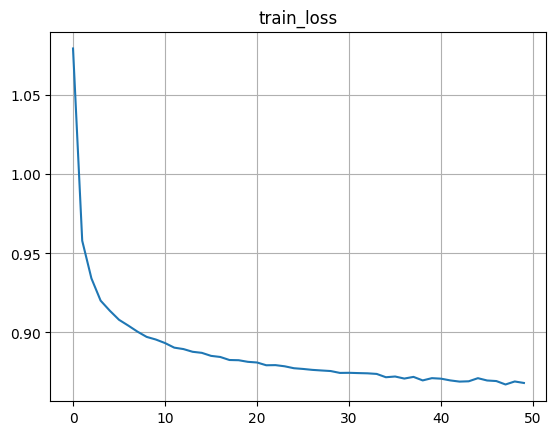

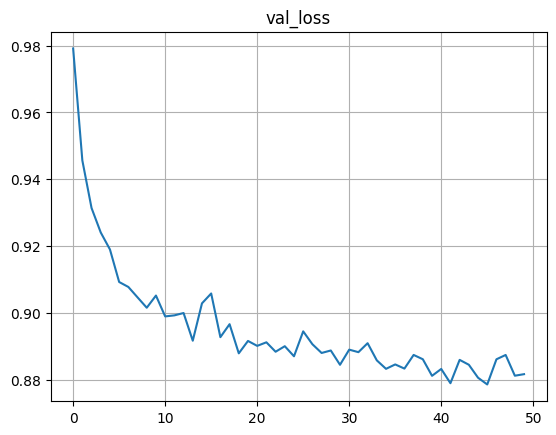

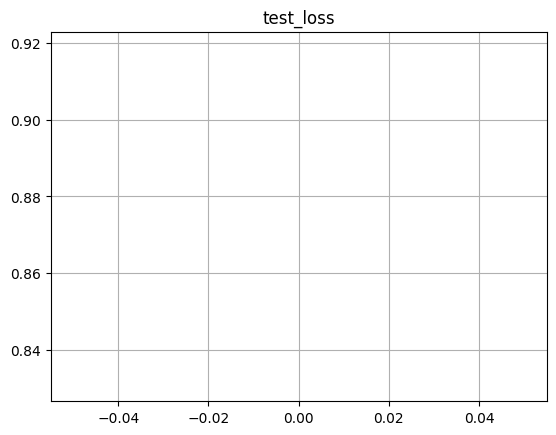

In [10]:
# make a dictionary with the losses as keys and the values as lists
loss_data = {}
loss_data["train_loss"] = train_loss
loss_data["val_loss"] = val_loss
loss_data["test_loss"] = np.mean(test_loss)

accuracy_data = {}
accuracy_data["train_accuracy"] = train_accuracy
accuracy_data["val_accuracy"] = val_accuracy
accuracy_data["test_accuracy"] = np.mean(test_accuracy)


loss_plots(loss_data, invidual_plots=True)
# accuracy_plots(accuracy_data)

# combine to one dict
data = loss_data | accuracy_data

# save the data
df = pd.DataFrame(data)
try:
    old_df = pd.read_csv(TRAIN_DATA_DIR + MODEL_NAME + "data.csv")
    df = pd.concat([old_df, df])
except:
    pass
df.to_csv(TRAIN_DATA_DIR + MODEL_NAME + "data.csv", index=False)

